In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn import metrics
%matplotlib inline

In [ ]:
#read the dataset
data = pd.read_csv('propublica_data_for_fairml.csv')
len(data)

6172

In [ ]:
violent = False

if violent:
    fname ='data/compas-scores-two-years-violent.csv'
    decile_col = 'v_decile_score'
    score_col = 'v_score_text'
else:
    fname ='data/compas-scores-two-years.csv'
    decile_col = 'decile_score'
    score_col = 'score_text'

In [ ]:
cv = pd.read_csv(fname)
cv.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [ ]:
cv.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [ ]:
cv = cv[
    (cv.days_b_screening_arrest <= 30) &  
    (cv.days_b_screening_arrest >= -30) &  
    (cv.is_recid != -1) &
    (cv.c_charge_degree != 'O') &
    (cv[score_col] != 'N/A')
]

cv.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
cv.shape

(6172, 53)

In [ ]:
# age value coutns
cv.age_cat.value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [ ]:
# race value counts
cv.race.value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [ ]:
# COMPAS decile score value counts
cv[decile_col].value_counts()

1     1286
2      822
4      666
3      647
5      582
6      529
7      496
9      420
8      420
10     304
Name: decile_score, dtype: int64

In [ ]:
# COMPAS text score value counts
cv[score_col].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

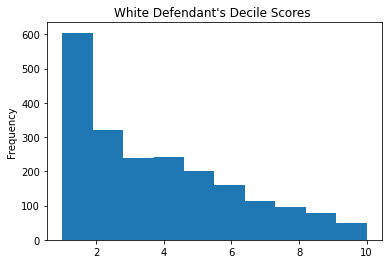

In [ ]:
# Histogram of decile scores for White
cv[cv.race == 'Caucasian'][decile_col].plot(kind='hist', title='White Defendant\'s Decile Scores ')

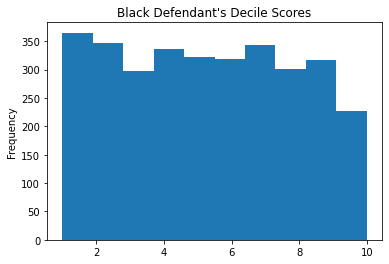

In [ ]:
# Histogram of decile scores for Black
cv[cv.race == 'African-American'][decile_col].plot(kind='hist', title='Black Defendant\'s Decile Scores')

In [ ]:
# recidivism value counts
cv.two_year_recid.value_counts()

0    3363
1    2809
Name: two_year_recid, dtype: int64

In [ ]:
# recidivism rates by race
recid_race = pd.crosstab(cv.race, cv.two_year_recid)
recid_race['rate'] = recid_race[1] / recid_race.sum(axis=1)
recid_race

two_year_recid,0,1,rate
race,,,
African-American,1514,1661,0.523150
Asian,23,8,0.258065
Caucasian,1281,822,0.390870
Hispanic,320,189,0.371316
Native American,6,5,0.454545
Other,219,124,0.361516


In [ ]:
# recidivism rates by sex
recid_sex = pd.crosstab(cv.sex, cv.two_year_recid)
recid_sex['rate'] = recid_sex[1] / recid_sex.sum(axis=1)
recid_sex

two_year_recid,0,1,rate
sex,,,
Female,762,413,0.351489
Male,2601,2396,0.479488


In [ ]:
# high risk rates by race
score_race = pd.crosstab(cv.race, cv[score_col])
score_race['High risk rate'] = score_race['High'] / score_race.sum(axis=1)
score_race

score_text,High,Low,Medium,High risk rate
race,,,,
African-American,845,1346,984,0.266142
Asian,3,24,4,0.096774
Caucasian,223,1407,473,0.106039
Hispanic,47,368,94,0.092338
Native American,4,3,4,0.363636
Other,22,273,48,0.064140


In [ ]:
# high risk rates by sex
score_sex = pd.crosstab(cv.sex, cv[score_col])
score_sex['High risk rate'] = score_sex['High'] / score_sex.sum(axis=1)
score_sex

score_text,High,Low,Medium,High risk rate
sex,,,,
Female,151,699,325,0.128511
Male,993,2722,1282,0.198719


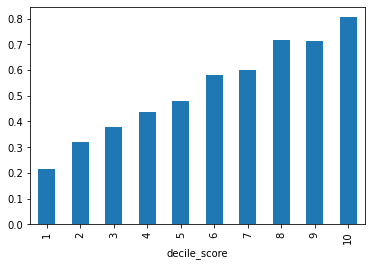

In [ ]:
# probability of recidivism by decile
cv.groupby(decile_col).mean()['two_year_recid'].plot(kind='bar')

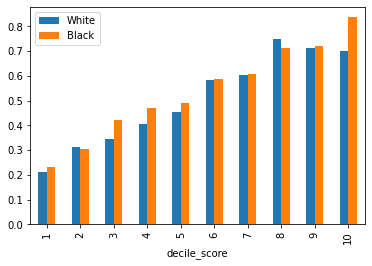

In [ ]:
# probability of recidivism by decile and race
b = cv[cv.race=='African-American'].groupby([decile_col]).mean()['two_year_recid']
w = cv[cv.race=='Caucasian'].groupby([decile_col]).mean()['two_year_recid']

a = pd.concat([w,b], axis=1)
a.columns = ['White','Black']
a.plot.bar()

In [ ]:
# COMPAS recidivism confusion matrix
cv['guessed_recid'] = cv[score_col] != 'Low'
cv['actual_recid'] = cv.two_year_recid == 1
cm = pd.crosstab(cv.actual_recid, cv.guessed_recid)
cm # for "confusion matrix"

guessed_recid,False,True
actual_recid,,
False,2345,1018
True,1076,1733


In [ ]:
# The usual definitions. First index is predicted, second is actual
TN = cm[False][False]
TP = cm[True][True]
FN = cm[False][True]
FP = cm[True][False]

In [ ]:
# PPV
TP / (TP + FP)

# FPR
FP / (FP + TN)

0.30270591733571217

In [ ]:
P = TP + FN
N = TN + FP

In [ ]:
# Equivalent definition of FPR that might be easier to understand, N in denominator
FP / N

0.30270591733571217

In [ ]:
# FNR
FN / (FN + TP)

0.38305446778212887

In [ ]:
# Alternate form with P in denominator
FN / P

0.38305446778212887

In [ ]:
# cm is a confusion matrix. The rows are guessed, the columns are actual 
def print_ppv_fpv(cm):
    # the indices here are [col][row] or [actual][guessed]
    TN = cm[False][False]   
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]
    print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
    print('PPV: ', TP / (TP + FP))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()

def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    print(cm)
    print()
    print_ppv_fpv(cm)

In [ ]:
print('White')
subset = cv[cv.race == 'Caucasian']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Black')
subset = cv[cv.race == 'African-American']
print_metrics(subset.guessed_recid, subset.actual_recid)

White
actual   False  True 
guessed              
False      999    408
True       282    414

Accuracy:  0.6718972895863052
PPV:  0.5948275862068966
FPR:  0.22014051522248243
FNR:  0.49635036496350365

Black
actual   False  True 
guessed              
False      873    473
True       641   1188

Accuracy:  0.6491338582677165
PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298



In [ ]:
# build up dummy variables for age, race, gender
features = pd.concat(
    [pd.get_dummies(cv.age_cat, prefix='age'),
     pd.get_dummies(cv.sex, prefix='sex'),
     pd.get_dummies(cv.c_charge_degree, prefix='degree'), # felony or misdemeanor charge ('f' or 'm')
     cv.priors_count],
    axis=1)

# We should have one less dummy variable than the number of categories, to avoid the "dummy variable trap"
# See https://www.quora.com/When-do-I-fall-in-the-dummy-variable-trap
features.drop(['age_25 - 45', 'sex_Female', 'degree_M'], axis=1, inplace=True)

# Try to predict whether someone is re-arrested
target = cv.two_year_recid


LogisticRegression()

In [ ]:
# Examine regression coefficients
coeffs = pd.DataFrame(np.exp(lr.coef_), columns=features.columns)
coeffs

,age_Greater than 45,age_Less than 25,sex_Male,degree_F,priors_count
0,0.505402,2.10855,1.403791,1.253803,1.185499


In [ ]:
# Crosstab for our predictive model
y_pred = lr.predict(x)
guessed=pd.Series(y_pred)==1

actual=cv.two_year_recid==1

cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
cm

actual,False,True
guessed,,
False,2568,1239
True,795,1570


In [ ]:
print_ppv_fpv(cm)

Accuracy:  0.670447180816591
PPV:  0.6638477801268499
FPR:  0.23639607493309545
FNR:  0.4410822356710573



In [ ]:
print('White')
subset = cv.race == 'Caucasian'
print_metrics(guessed[subset], actual[subset])

print('Black')
subset = cv.race == 'African-American'
print_metrics(guessed[subset], actual[subset])

White
actual   False  True 
guessed              
False     1068    494
True       213    328

Accuracy:  0.6638135996195911
PPV:  0.6062846580406654
FPR:  0.16627634660421545
FNR:  0.6009732360097324

Black
actual   False  True 
guessed              
False     1026    564
True       488   1097

Accuracy:  0.6686614173228347
PPV:  0.6921135646687697
FPR:  0.32232496697490093
FNR:  0.3395544852498495



'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.


ValueError: ignored